In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

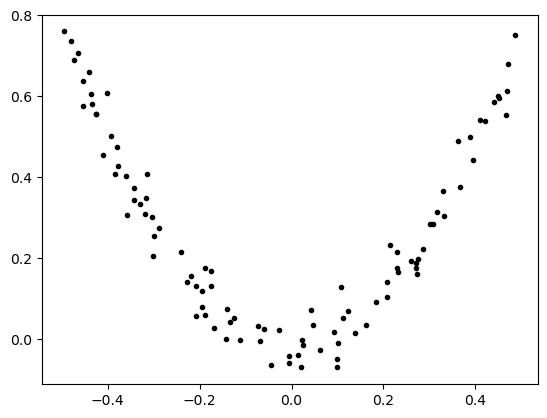

In [3]:
plt.plot(X,y,'k.')

plt.show()

In [4]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [5]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [6]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

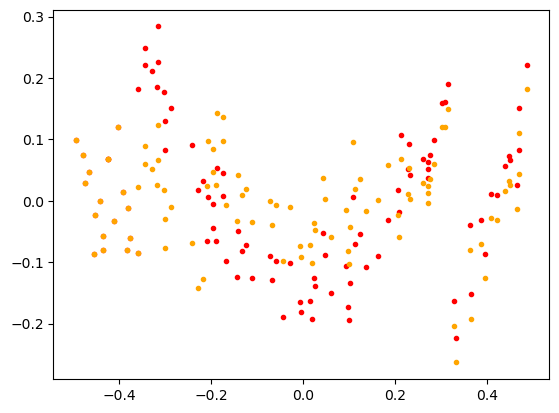

In [7]:
plt.plot(X,y2,'r.')
plt.plot(X,y3,'.', c='orange')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [8]:
X_new = np.array([[0.8]])

In [9]:
y_pred = [tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)]

In [10]:
y_pred

[array([0.52856846]), array([0.03991297]), array([0.18178637])]

In [11]:
y_pred = sum(y_pred)
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

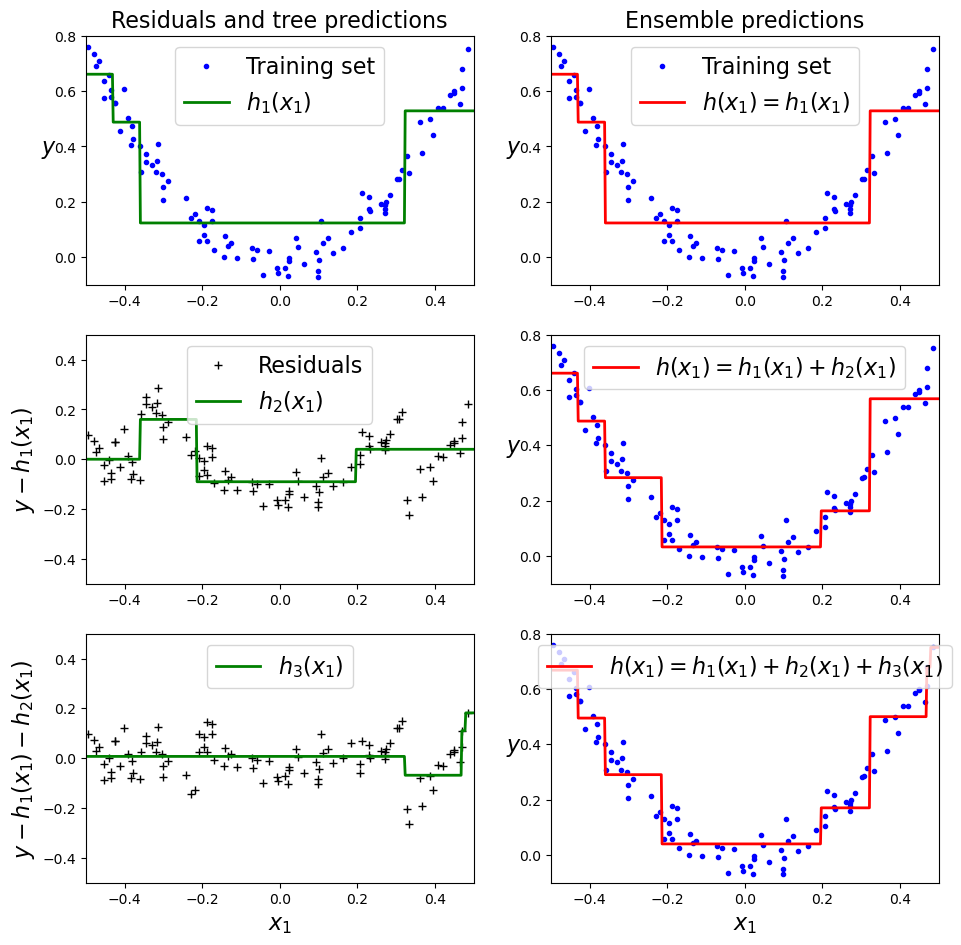

In [12]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.savefig("gradient_boosting_plot.png")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [2]:
df = pd.read_csv('titanic.csv')
df.dropna(inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [3]:
df.convert_dtypes().dtypes

PassengerId      Int64
Survived         Int64
Pclass           Int64
Name            string
Sex             string
Age            Float64
SibSp            Int64
Parch            Int64
Ticket          string
Fare           Float64
Cabin           string
Embarked        string
dtype: object

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [5]:
df.select_dtypes(include='object').head()

,Name,Sex,Ticket,Cabin,Embarked
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
6,"McCarthy, Mr. Timothy J",male,17463,E46,S
10,"Sandstrom, Miss. Marguerite Rut",female,PP 9549,G6,S
11,"Bonnell, Miss. Elizabeth",female,113783,C103,S


In [6]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,Name,183
1,Sex,2
2,Ticket,127
3,Cabin,133
4,Embarked,3


In [24]:
df['Cabin'].unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'D33', 'B30', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26',
       'C110', 'B58 B60', 'E101', 'D47', 'B86', 'F2', 'C2', 'B19', 'A7',
       'C49', 'F4', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'B49',
       'D', 'C22 C26', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'E33', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'C52', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'E12', 'E63', 'B37', 'C30', 'D20', 'B79',
       'E25', 'D46', 'B73', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16',
       'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9',
       'A23', 'B50', 'A26', 'D48', 'E58', 'B71', 'B51 B53 B55', 'D49',
       'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C126', 'C45', 'E8',
       'B101', 'C46', 'D30', 'E121', 'D11', 'E77', 'B3', 'D6', 'B

***Dropping+Ignoring `Cabin`,`Name`,`Ticket` categorical features to streamline demonstration***

**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [7]:
dft = pd.DataFrame(df.drop(df.columns,axis =1)).merge(pd.get_dummies(df.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(dft.shape)
dft.head()

(183, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [8]:
dft.isna().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [9]:
df = dft.copy()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,183.0,0.672131,0.470725,0.00,0.0,1.0,1.0,1.0000
Pclass,183.0,1.191257,0.515187,1.00,1.0,1.0,1.0,3.0000
Age,183.0,35.674426,15.643866,0.92,24.0,36.0,47.5,80.0000
SibSp,183.0,0.464481,0.644159,0.00,0.0,0.0,1.0,3.0000
Parch,183.0,0.475410,0.754617,0.00,0.0,0.0,1.0,4.0000
Fare,183.0,78.682469,76.347843,0.00,29.7,57.0,90.0,512.3292
Sex_female,183.0,0.480874,0.501005,0.00,0.0,0.0,1.0,1.0000
Sex_male,183.0,0.519126,0.501005,0.00,0.0,1.0,1.0,1.0000
Embarked_C,183.0,0.355191,0.479884,0.00,0.0,0.0,1.0,1.0000
Embarked_Q,183.0,0.010929,0.104254,0.00,0.0,0.0,0.0,1.0000


**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [12]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [13]:
binary_columns = X.columns[X.columns.str.find('_')>0]

In [14]:
scale_columns = X.columns[X.columns.str.find('_')<0]

In [15]:
binary_columns

Index(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype='object')

In [16]:
scale_columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [17]:
X.shape, y.shape

((183, 10), (183,))

In [39]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,1
6,1,54.0,0,0,51.8625,0,1,0,0,1
10,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,58.0,0,0,26.5500,1,0,0,0,1


**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [34]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,-0.372256,0.149065,0.833628,-0.631730,-0.097180,1.039012,-1.039012,1.347362,-0.105118,-1.315805
3,-0.372256,-0.043230,0.833628,-0.631730,-0.335997,1.039012,-1.039012,-0.742191,-0.105118,0.759991
6,-0.372256,1.174636,-0.723044,-0.631730,-0.352250,-0.962453,0.962453,-0.742191,-0.105118,0.759991
10,3.520480,-2.030273,0.833628,0.697081,-0.814070,1.039012,-1.039012,-0.742191,-0.105118,0.759991
11,-0.372256,1.431029,-0.723044,-0.631730,-0.684702,1.039012,-1.039012,-0.742191,-0.105118,0.759991


*do not scale encoded data?*

In [23]:
X_scaled = preprocessing.StandardScaler().fit_transform(X[scale_columns])
X_scaled = pd.DataFrame(X_scaled, columns=scale_columns, index=X.index)
X_scaled.head()

,Pclass,Age,SibSp,Parch,Fare
1,-0.372256,0.149065,0.833628,-0.631730,-0.097180
3,-0.372256,-0.043230,0.833628,-0.631730,-0.335997
6,-0.372256,1.174636,-0.723044,-0.631730,-0.352250
10,3.520480,-2.030273,0.833628,0.697081,-0.814070
11,-0.372256,1.431029,-0.723044,-0.631730,-0.684702


In [24]:
X_scaled = pd.concat([X_scaled, X[binary_columns]], axis=1)

In [25]:
X_scaled.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,-0.372256,0.149065,0.833628,-0.631730,-0.097180,1,0,1,0,0
3,-0.372256,-0.043230,0.833628,-0.631730,-0.335997,1,0,0,0,1
6,-0.372256,1.174636,-0.723044,-0.631730,-0.352250,0,1,0,0,1
10,3.520480,-2.030273,0.833628,0.697081,-0.814070,1,0,0,0,1
11,-0.372256,1.431029,-0.723044,-0.631730,-0.684702,1,0,0,0,1


In [26]:
X_scaled.shape

(183, 10)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [19]:
from sklearn.model_selection import train_test_split


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [21]:
print('scaled all data')
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
results = pd.DataFrame()
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    results.loc[learning_rate,'Accuracy_Training'] = gb.score(X_train, y_train)
    results.loc[learning_rate,'Accuracy_Testing'] = gb.score(X_test, y_test)
    print()

scaled all data
Learning rate:  0.05
Accuracy score (training): 0.708
Accuracy score (validation): 0.696

Learning rate:  0.1
Accuracy score (training): 0.796
Accuracy score (validation): 0.848

Learning rate:  0.25
Accuracy score (training): 0.818
Accuracy score (validation): 0.804

Learning rate:  0.5
Accuracy score (training): 0.839
Accuracy score (validation): 0.804

Learning rate:  0.75
Accuracy score (training): 0.876
Accuracy score (validation): 0.804

Learning rate:  1
Accuracy score (training): 0.861
Accuracy score (validation): 0.761



In [22]:
results.sort_values('Accuracy_Testing', ascending=False)

,Accuracy_Training,Accuracy_Testing
0.10,0.795620,0.847826
0.25,0.817518,0.804348
0.50,0.839416,0.804348
0.75,0.875912,0.804348
1.00,0.861314,0.760870
0.05,0.708029,0.695652


**Did not scale binary features**

In [28]:
print('did NOT scale encoded features')
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
results = pd.DataFrame()
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    results.loc[learning_rate,'Accuracy_Training'] = gb.score(X_train, y_train)
    results.loc[learning_rate,'Accuracy_Testing'] = gb.score(X_test, y_test)
    print()

did NOT scale encoded features
Learning rate:  0.05
Accuracy score (training): 0.715
Accuracy score (validation): 0.652

Learning rate:  0.1
Accuracy score (training): 0.847
Accuracy score (validation): 0.739

Learning rate:  0.25
Accuracy score (training): 0.869
Accuracy score (validation): 0.652

Learning rate:  0.5
Accuracy score (training): 0.891
Accuracy score (validation): 0.630

Learning rate:  0.75
Accuracy score (training): 0.905
Accuracy score (validation): 0.674

Learning rate:  1
Accuracy score (training): 0.942
Accuracy score (validation): 0.739



In [29]:
results.sort_values('Accuracy_Testing', ascending=False)

,Accuracy_Training,Accuracy_Testing
0.10,0.846715,0.739130
1.00,0.941606,0.739130
0.75,0.905109,0.673913
0.05,0.715328,0.652174
0.25,0.868613,0.652174
0.50,0.890511,0.630435


**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

**Learning Rate: 0.10**

Best testing accuracy, answers seem to vary

In [37]:
gb_answer = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_features=2, max_depth = 2, random_state = 0)
gb_answer.fit(X_train, y_train)
y_pred = gb_answer.predict(X_scaled)
gb_answer.score(X_test, y_test)

0.7391304347826086

In [38]:
cm = confusion_matrix(y, y_pred)
cm

array([[ 27,  33],
       [  5, 118]], dtype=int64)

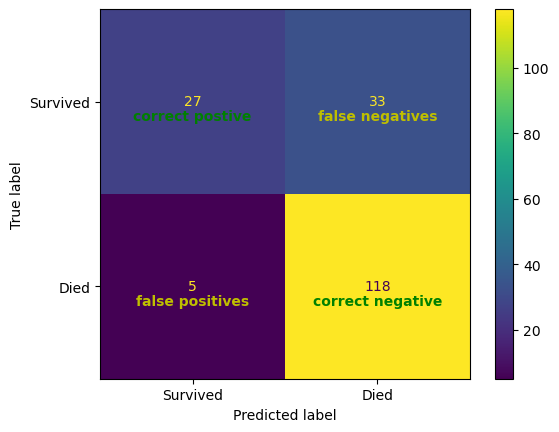

In [39]:

disp = ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died'])
disp.plot()
plt.text(1,0.1,'false negatives', color='y', ha='center', fontweight='bold')
plt.text(0,1.1,'false positives', color='y', ha='center', fontweight='bold')

plt.text(0,0.1,'correct postive', color='g', ha='center', fontweight='bold')
plt.text(1,1.1,'correct negative', color='g', ha='center', fontweight='bold')

plt.show()

In [40]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.45      0.59        60
           1       0.78      0.96      0.86       123

    accuracy                           0.79       183
   macro avg       0.81      0.70      0.72       183
weighted avg       0.80      0.79      0.77       183



**<font color='teal'>Calculate the ROC for the model as well.</font>**

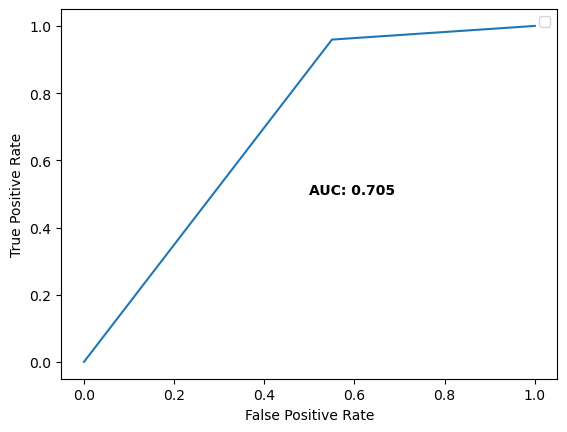

In [41]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.text(0.5, 0.5, f'AUC: {round(roc_auc,3)}', fontweight='bold')
plt.legend([])
plt.show()

## Learning Rate: 0.05
*worse performance with this split*

Test Accuracy
 0.6739130434782609
Confusion Matrix
 [[  7  53]
 [  0 123]]


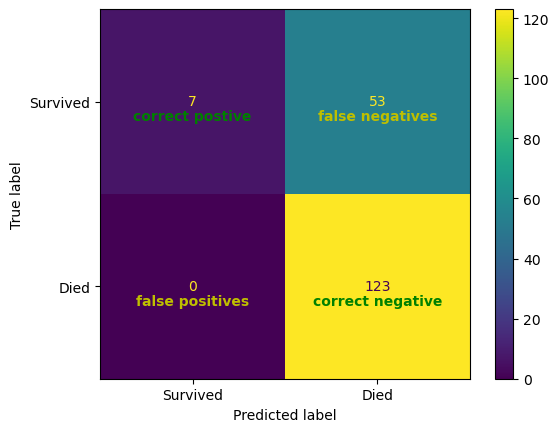

In [42]:
gb_answer = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=2, max_depth = 2, random_state = 0)
gb_answer.fit(X_train, y_train)
y_pred = gb_answer.predict(X_scaled)
print('Test Accuracy\n',gb_answer.score(X_test, y_test))

cm = confusion_matrix(y, y_pred)
print('Confusion Matrix\n',cm)


disp = ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died'])
disp.plot()
plt.text(1,0.1,'false negatives', color='y', ha='center', fontweight='bold')
plt.text(0,1.1,'false positives', color='y', ha='center', fontweight='bold')

plt.text(0,0.1,'correct postive', color='g', ha='center', fontweight='bold')
plt.text(1,1.1,'correct negative', color='g', ha='center', fontweight='bold')
plt.show()

In [43]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        60
           1       0.70      1.00      0.82       123

    accuracy                           0.71       183
   macro avg       0.85      0.56      0.52       183
weighted avg       0.80      0.71      0.62       183



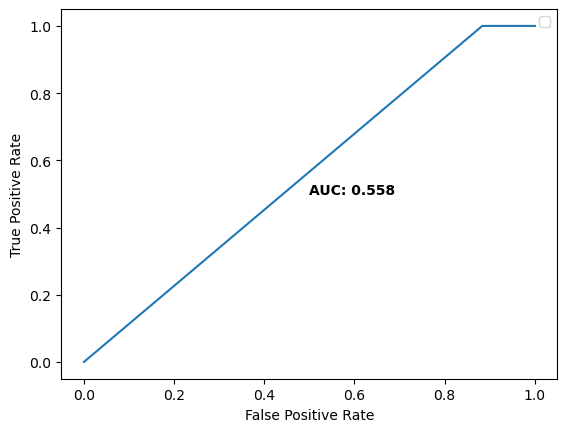

In [44]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.text(0.5, 0.5, f'AUC: {round(roc_auc,3)}', fontweight='bold')
plt.legend([])
plt.show()